# ODM2 Example 3: Use ODM2 API to Retrieve Data for Manipulation or Analysis

This example shows how to connect to an ODM2 database using the ODM2 Python API, retrieve data, and use it for analysis or visualization. This example uses SQLite for the database because it doesn't require a server. However, the ODM2 Python API demonstrated here can be used with ODM2 databases implemented in:
* Microsoft SQL Server
* MySQL
* PostgresSQL
* SQLite

More details of the ODM2 Python API and its source code and latest development can be found at: https://github.com/ODM2/ODM2PythonAPI

First load the required libraries.

In [1]:
%matplotlib inline

import sys
import os
import sqlite3

import matplotlib.pyplot as plt

from odm2api.ODMconnection import dbconnection
import odm2api.ODM2.services.readService as odm2rs

### Make a Connection to the ODM2 SQLite Database

For this example, an ODM2 SQLite database has been created and loaded with water quality sample data from multiple monitoring sites in the iUTAH Gradients Along Mountain to Urban Transitions (GAMUT) water quality monitoring network. Water quality samples have been collected and analyzed for nitrogen, phosphorus, total coliform, E-coli, and some water isotopes.

The example database is located in the "notebooks/data" directory on this Jupyter server.

In [2]:
# temporary hard-wiring; ultimately, need to be able to extract 
# the base directory path automatically
dpth = "/home/mayorga/Desktop/CZOData-BiGCZ-NOW/2013_NSF_BiGCZ_SSI/ProjectWork/ProjectMeetings/2017_11_UserWorkshop/wshp2017_tutorial_content"

dbname_sqlite = "ODM2_iUTAH_Specimen_Example.sqlite"

# PROBABLY BEST IF THE PATH TO THE SQLITE FILE IS DEFINED ONCE, ABOVE, AS A VARIABLE, 
# THEN REUSED THROUGHOUT THE NOTEBOOK

sqlite_pth = os.path.join(dpth, "data", dbname_sqlite)

In [3]:
try:
    session_factory = dbconnection.createConnection('sqlite', sqlite_pth, 2.0)
    read = odm2rs.ReadODM2(session_factory)
    print("Datbase connection successful!")
except Exception as e:
    print("Unable to establish connection to the database: ", e)

Datbase connection successful!


### Run Some Basic Queries on the ODM2 Database

This code shows some example of how to use the API to run simple queries on the ODM2 database. Simple query functions like **getVariables( )** return objects similar to the entities in ODM2, and individual attributes can then be retrieved from the objects returned. 

In [4]:
# Get all of the Variables from the ODM2 database and print their IDs, codes, and names
allVars = read.getVariables()
print("\n-------- Information about Variables --------- \n")
for x in allVars:
    print("VariableID = " + str(x.VariableID) + ", VariableCode = " + x.VariableCode + 
          ", VariableName = " + x.VariableNameCV)


-------- Information about Variables --------- 

VariableID = 1, VariableCode = TN, VariableName = Nitrogen, total
VariableID = 2, VariableCode = TP, VariableName = Phosphorus, total
VariableID = 3, VariableCode = Nitrate, VariableName = Nitrogen, dissolved nitrite (NO2) + nitrate (NO3)
VariableID = 4, VariableCode = Ammonia, VariableName = Nitrogen, NH4
VariableID = 5, VariableCode = Phosphate, VariableName = Phosphorus, orthophosphate dissolved
VariableID = 6, VariableCode = Tcoliform, VariableName = Coliform, total
VariableID = 7, VariableCode = E-Coli, VariableName = E-Coli
VariableID = 8, VariableCode = DOC, VariableName = Carbon, dissolved organic
VariableID = 9, VariableCode = TDN, VariableName = Nitrogen, total dissolved
VariableID = 10, VariableCode = Abs254, VariableName = Absorbance
VariableID = 11, VariableCode = SUVA, VariableName = SUVA254
VariableID = 12, VariableCode = TSS, VariableName = Solids, volatile suspended
VariableID = 13, VariableCode = VSS, VariableName = So

In [5]:
# As another example of a simple query, get all of the people from the database
allPeople = read.getPeople()
print("\n-------- Information about People --------- \n")
# Print the first few people from the database
for x in allPeople[:4]:
    print(x.PersonFirstName + " " + x.PersonLastName)


-------- Information about People --------- 

Nancy Mesner
Dane Brophy
Ben Rider
Michelle  Baker


### Overloading API Functions with Arguments

Some of the API functions are overloaded with arguments that let you subset what is returned. For example, I can query the database using the **getSamplingFeatures( )** function and pass it a SamplingFeatureType of "Site" to return a list of those SamplingFeatures that are Sites.

In [6]:
# Get all of the SamplingFeatures from the ODM2 database that are Sites
try:
    print("\n-------- Information about Sites --------- \n")
    siteFeatures = read.getSamplingFeatures(type='Site')
    numSites = len(siteFeatures)
    print("There are " + str(numSites) + " sites in the ODM2 database.\n")
    # Print a few of the Attributes for a couple of the sites
    for x in siteFeatures[:2]:
        print(x.SamplingFeatureCode + ": " + x.SamplingFeatureName)
        print('Latitude: ' + str(x.Latitude))
        print('Longitude: ' + str(x.Longitude))
        print('SiteType: ' + x.SiteTypeCV + "\n")
except Exception as e:
    print("Unable to demo getSamplingFeatures: ", e)


-------- Information about Sites --------- 

There are 25 sites in the ODM2 database.

RB_1300E: Red Butte Creek at 1300E (downstream of spring)
Latitude: 40.745078
Longitude: -111.854449
SiteType: Stream

RB_1300ESpring: Spring that enters Red Butte Creek at 1300E
Latitude: 40.745106
Longitude: -111.854389
SiteType: Spring



### Get Objects and Related Objects from the Database

This code shows some examples of how objects and related objects can be retrieved using the API. In the following, se use the **getSamplingFeatures( )** function to return a particular sampling feature by passing in its SamplingFeatureCode. This function returns a list of SamplingFeature objects, so just get the first one in the returned list.

In [7]:
# Get the SamplingFeature object for a particular SamplingFeature by passing its SamplingFeatureCode
try:
    sf = read.getSamplingFeatures(codes=['RB_1300E'])[0]
    print("\n-------- Information about an individual SamplingFeature --------- \n")
    print("SamplingFeatureID: " + str(sf.SamplingFeatureID))
    print("SamplingFeatureCode: " + sf.SamplingFeatureCode)
    print("SamplingFeatureName: " + sf.SamplingFeatureName)
    print("SamplingFeatureDescription: %s" % sf.SamplingFeatureDescription)
    print("SamplingFeatureGeotypeCV: %s" % sf.SamplingFeatureGeotypeCV)
    print("Elevation_m: %s" % str(sf.Elevation_m))
except Exception as e:
    print("Unable to demo getSamplingFeatures: ", e)


-------- Information about an individual SamplingFeature --------- 

SamplingFeatureID: 1
SamplingFeatureCode: RB_1300E
SamplingFeatureName: Red Butte Creek at 1300E (downstream of spring)
SamplingFeatureDescription: None
SamplingFeatureGeotypeCV: None
Elevation_m: 1356.0


You can also drill down and get objects linked by foreign keys. The API returns related objects in a nested hierarchy so they can be interrogated in an object oriented way. So, if I use the **getResults( )** function to return a Result from the database (e.g., a "Measurement" Result), I also get the associated Action that created that Result (e.g., a "Specimen analysis" Action).

In [8]:
print("\n------------ Foreign Key Example --------- \n")
try:
    # Call getResults, but return only the first Result
    firstResult = read.getResults()[0]
    print("The FeatureAction object for the Result is: ", firstResult.FeatureActionObj)
    print("The Action object for the Result is: ", firstResult.FeatureActionObj.ActionObj)
    
    # Or, print some of those attributes in a more human readable form:
    print("\nThe following are some of the attributes for the Action that created the Result: " +
          "\nActionTypeCV: " + firstResult.FeatureActionObj.ActionObj.ActionTypeCV + 
          "\nActionDescription: " + str(firstResult.FeatureActionObj.ActionObj.ActionDescription) + 
          "\nBeginDateTime: " + str(firstResult.FeatureActionObj.ActionObj.BeginDateTime) + 
          "\nEndDateTime: " + str(firstResult.FeatureActionObj.ActionObj.EndDateTime) + 
          "\nMethodName: " + firstResult.FeatureActionObj.ActionObj.MethodObj.MethodName + 
          "\nMethodDescription: " + firstResult.FeatureActionObj.ActionObj.MethodObj.MethodDescription)
except Exception as e:
    print("Unable to demo Foreign Key Example: ", e)


------------ Foreign Key Example --------- 

('The FeatureAction object for the Result is: ', <FeatureActions({'SamplingFeatureID': 26, '_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x7f099c5df690>, 'FeatureActionID': 992, 'ActionID': 992})>)
('The Action object for the Result is: ', <Actions({'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x7f099c5e6390>, 'MethodID': 2, 'ActionDescription': None, 'ActionFileLink': None, 'EndDateTime': None, 'BeginDateTime': datetime.datetime(2014, 10, 30, 0, 0), 'BeginDateTimeUTCOffset': -7, 'ActionTypeCV': u'specimenAnalysis', 'ActionID': 992, 'EndDateTimeUTCOffset': None})>)

The following are some of the attributes for the Action that created the Result: 
ActionTypeCV: specimenAnalysis
ActionDescription: None
BeginDateTime: 2014-10-30 00:00:00
EndDateTime: None
MethodName: Astoria Total Phosphorus
MethodDescription: Determination of total phosphorus by persulphate oxidation digestion and ascorbic acid met

### Get a Result and its Attributes

Because all of the objects are returned in a nested form, if you retrieve a result, you can interrogate it to get all of its related attributes. When a Result object is returned, it includes objects that contain information about Variable, Units, ProcessingLevel, and the related Action that created that Result.

In [9]:
# Get a particular Result
print("\n------- Example of Retrieving Attributes of a Result -------")
try:
    firstResult = read.getResults()[0]
    print(
        "The following are some of the attributes for the Result retrieved: \n" +
        "ResultID: " + str(firstResult.ResultID) + "\n" +
        "ResultTypeCV: " + firstResult.ResultTypeCV + "\n" +
        "ValueCount: " + str(firstResult.ValueCount) + "\n" +
        # Get the ProcessingLevel from the Result's ProcessingLevel object
        "ProcessingLevel: " + firstResult.ProcessingLevelObj.Definition + "\n" +
        "SampledMedium: " + firstResult.SampledMediumCV + "\n" +
        # Get the Variable information from the Result's Variable object
        "Variable: " + firstResult.VariableObj.VariableCode + ": " + firstResult.VariableObj.VariableNameCV + "\n" +
        # Get the Units information from the Result's Units object
        "Units: " + firstResult.UnitsObj.UnitsName + "\n" +
        # Get the Specimen information by drilling down into the result object
        "SamplingFeatureID: " + str(firstResult.FeatureActionObj.SamplingFeatureObj.SamplingFeatureID) + "\n" +
        "SamplingFeatureCode: " + firstResult.FeatureActionObj.SamplingFeatureObj.SamplingFeatureCode)
except Exception as e:
    print("Unable to demo example of retrieving Attributes of a Result: ", e)



------- Example of Retrieving Attributes of a Result -------
The following are some of the attributes for the Result retrieved: 
ResultID: 1
ResultTypeCV: measurement
ValueCount: 1
ProcessingLevel: Raw Data
SampledMedium: Liquid aqueous
Variable: TP: Phosphorus, total
Units: milligrams per liter
SamplingFeatureID: 26
SamplingFeatureCode: 3


The last block of code returns a particular Measurement Result. From that I can get the SamplingFeaureID (in this case 26) for the Specimen from which the Result was generated. But, if I want to figure out which Site the Specimen was collected at, I need to query the database to get the related Site SamplingFeature.  I can use **getRelatedSamplingFeatures( )** for this.  Once I've got the SamplingFeature for the Site, I could get the rest of the SamplingFeature attributes.

In [10]:
print("\n------- Example of Retrieving the Site at which a Specimen was Collected ------- \n")
# Get the site at which the specimen was collected - 
#   pass in the ID of the specimen and the relationship type
relatedSite = read.getRelatedSamplingFeatures(sfid=26, relationshiptype='wasCollectedAt')
print("SamplingFeatureID: " + str(relatedSite[0].SamplingFeatureID))
print("SamplingFeatureCode: " + relatedSite[0].SamplingFeatureCode)
print("SamplingFeatureName: " + relatedSite[0].SamplingFeatureName)
print("Latitude: " + str(relatedSite[0].SiteTypeCV))
print("Latitude: " + str(relatedSite[0].Latitude))
print("Longitude: " + str(relatedSite[0].Longitude))


------- Example of Retrieving the Site at which a Specimen was Collected ------- 

SamplingFeatureID: 1
SamplingFeatureCode: RB_1300E
SamplingFeatureName: Red Butte Creek at 1300E (downstream of spring)
Latitude: Stream
Latitude: 40.745078
Longitude: -111.854449


### Return Results and Data Values for a Particular Site/Variable

From the list of Variables returned above and the information about the SamplingFeature I queried above, I know that VariableID = 2 for Total Phosphorus and SiteID = 1 for the Red Butte Creek site at 1300E. I can use the **getResults( )** function to get all of the Total Phosphorus results for this site by passing in the VariableID and the SiteID.

In [11]:
# Get a list of Results at a particular Site, for a particular Variable, and of type "Measurement"
print("\n------- Example of Retrieving a List of Results for a Site/Variable Combination ------- \n")
 
variableID = 2   # Total Phosphorus
siteID = 1       # Red Butte Creek at 1300 E

try:
    results = read.getResults(siteid = siteID, variableid = variableID, type = "measurement")
    print("ResultCount: " + str(len(results)) + "\n")
    # Get the list of ResultIDs so I can retrieve the data values associated with all of the results
    resultIDList = []
    for x in results:
        resultIDList.append(x.ResultID)
    print("The following is the list of ResultIDs for the Total Phosphorus measurements at this site:\n")
    print(resultIDList)
except Exception as e:
    print("Unable to demo Example of retrieving Results of a time Series Result: ", e)


------- Example of Retrieving a List of Results for a Site/Variable Combination ------- 

ResultCount: 18

The following is the list of ResultIDs for the Total Phosphorus measurements at this site:

[1, 10, 99, 196, 312, 463, 557, 598, 600, 751, 810, 835, 857, 980, 1322, 1335, 1996, 2010]


### Retrieve the Results and Create a Quick Plot of the Data

Finally, I can retrieve all of the data values associated with the list of Results I just retrieved. In ODM2, water chemistry measurements are stored as "Measurement" results. Each "Measurement" Result has a single data value associated with it. So, for convenience, the **getResultValues( )** function allows you to pass in a list of ResultIDs so you can get the data values for all of them back in a Pandas data frame object, which is easier to work with. Once I've got the data in a Pandas data frame object, I can use the **plot( )** function directly on the data frame to create a quick visualization.

In [12]:
# Get all of the data values for the Results in the list created above
print("\n-------- Example of Retrieving Measurement Result Values --------- \n")
# Call getResultValues, which returns a Pandas Data Frame with the data
resultValues = read.getResultValues(resultids=resultIDList)

resultValues.head()


-------- Example of Retrieving Measurement Result Values --------- 



,valueid,resultid,datavalue,valuedatetime,valuedatetimeutcoffset
0,1,1,0.0100,2014-10-30,-7
1,10,10,0.0574,2015-08-13,-7
2,99,99,0.0424,2015-09-07,-7
3,196,196,0.0167,2015-02-25,-7
4,312,312,0.0102,2015-03-25,-7


In [13]:
resultValues.dtypes

valueid                            int64
resultid                           int64
datavalue                        float64
valuedatetime             datetime64[ns]
valuedatetimeutcoffset             int64
dtype: object

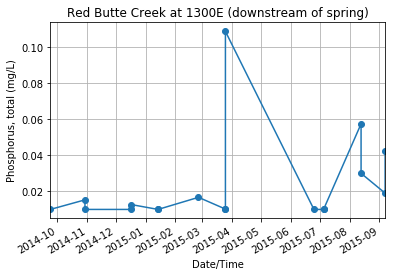

In [14]:
# Plot the time sequence of Measurement Result Values 
try:
    resultValues.plot(x='valuedatetime', y='datavalue', kind='line', use_index=True, 
                      linestyle='solid', style='o', title=relatedSite[0].SamplingFeatureName)
    ax = plt.gca()
    ax.set_ylabel('Phosphorus, total (mg/L)')  # REPLACE THIS WITH STRING PULLED FROM DB
    ax.set_xlabel('Date/Time')
    ax.grid(True)
    ax.legend().set_visible(False)
except Exception as e:
    print("Unable to demo plotting of data values: ", e)